# Correlations before and after attack

Demonstration with one new qcd file, will repeat with old set of qcd files used for training later I guess

### Loading modules

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
import uproot    # this would be version 3
import uproot4

In [55]:
import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

### Configure the device

In [56]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Plot styling

In [121]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

### Opening the files

##### First one of the new set of QCD files

In [58]:
#file = "root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1PFNanoV2/210101_173148/0001/nano_mc2017_1-1048.root"

Now also available locally

In [59]:
file = "/home/um106329/aisafety/information_datasets/nano_mc2017_1-1048.root"

In [60]:
tree = uproot4.open(file, library='pd')['Events']
#tree.keys()

In [61]:
jet_input_branches = ["event", "Jet_pt","Jet_eta", "Jet_hadronFlavour", "Jet_nBHadrons", "Jet_btagDeepB", "Jet_btagDeepFlavB"]
deepCSV_input_branches = [x for x in tree.keys() if 'Jet_DeepCSV' in x]
jet_input_branches.extend(deepCSV_input_branches)
deepCSV_input_branches = ["Jet_pt", "Jet_eta"] + deepCSV_input_branches

In [62]:
df = tree.arrays(jet_input_branches, library='pd')
df.unstack()
df

event      Jet_pt   Jet_eta  Jet_hadronFlavour  \
entry subentry                                                       
0     0          76071929  671.500000 -0.122818                  0   
      1          76071929  448.500000  0.105759                  0   
      2          76071929  270.750000 -0.360352                  0   
      3          76071929   41.687500 -0.462341                  0   
1     0          76071845  400.750000 -0.002752                  0   
...                   ...         ...       ...                ...   
7738  4         174676315   27.671875  2.825684                  0   
      5         174676315   23.281250 -2.705078                  0   
      6         174676315   20.093750  0.387329                  0   
      7         174676315   19.109375 -3.816406                  0   
      8         174676315   16.796875 -1.479736                  0   

                Jet_nBHadrons  Jet_btagDeepB  Jet_btagDeepFlavB  \
entry subentry                                                    
0     0                     0       0.112854           0.086853   
      1                     0       0.030960           0.021286   
      2                     0       0.048584           0.020294   
      3                     0       0.071228           0.332520   
1     0                     0       0.025467           0.014442   
...                       ...            ...                ...   
7738  4                     0      -1.000000           0.207275   
      5                     0       0.194458           0.283691   
      6                     0      -1.000000           0.041840   
      7                     0      -1.000000           0.192505   
      8                     0       0.137573           0.104614   

                Jet_DeepCSV_flightDistance2dSig  \
entry subentry                                    
0     0                               20.640625   
      1                             -999.000000   
      2                                3.375000   
      3                                4.468750   
1     0                             -999.000000   
...                                         ...   
7738  4                             -999.000000   
      5                             -999.000000   
      6                             -999.000000   
      7                             -999.000000   
      8                             -999.000000   

                Jet_DeepCSV_flightDistance2dVal  \
entry subentry                                    
0     0                                1.925781   
      1                             -999.000000   
      2                                0.131958   
      3                                0.060944   
1     0                             -999.000000   
...                                         ...   
7738  4                             -999.000000   
      5                             -999.000000   
      6                             -999.000000   
      7                             -999.000000   
      8                             -999.000000   

                Jet_DeepCSV_flightDistance3dSig  ...  \
entry subentry                                   ...   
0     0                               20.671875  ...   
      1                             -999.000000  ...   
      2                                3.345703  ...   
      3                                4.500000  ...   
1     0                             -999.000000  ...   
...                                         ...  ...   
7738  4                             -999.000000  ...   
      5                             -999.000000  ...   
      6                             -999.000000  ...   
      7                             -999.000000  ...   
      8                             -999.000000  ...   

                Jet_DeepCSV_trackSumJetDeltaR  Jet_DeepCSV_trackSumJetEtRatio  \
entry subentry                                                                  
0     0           

In [63]:
df = df[(df['Jet_pt']>25) & (abs(df['Jet_eta'])<2.5)]

In [64]:
df = df.reset_index()

### Cleaning of the deepCSV inputs

In [65]:
pd.options.mode.use_inf_as_na = False

In [66]:
df[deepCSV_input_branches]

,Jet_pt,Jet_eta,Jet_DeepCSV_flightDistance2dSig,Jet_DeepCSV_flightDistance2dVal,Jet_DeepCSV_flightDistance3dSig,Jet_DeepCSV_flightDistance3dVal,Jet_DeepCSV_trackDecayLenVal_0,Jet_DeepCSV_trackDecayLenVal_1,Jet_DeepCSV_trackDecayLenVal_2,Jet_DeepCSV_trackDecayLenVal_3,...,Jet_DeepCSV_trackSumJetDeltaR,Jet_DeepCSV_trackSumJetEtRatio,Jet_DeepCSV_vertexCategory,Jet_DeepCSV_vertexEnergyRatio,Jet_DeepCSV_vertexJetDeltaR,Jet_DeepCSV_vertexMass,Jet_DeepCSV_jetNSecondaryVertices,Jet_DeepCSV_jetNSelectedTracks,Jet_DeepCSV_jetNTracksEtaRel,Jet_DeepCSV_vertexNTracks
0,671.50000,-0.122818,20.640625,1.925781,20.671875,2.015625,0.040619,0.002913,2.525330e-03,3.137207e-02,...,0.015335,0.459961,0.0,0.014397,0.187744,0.617188,1,14,2,2
1,448.50000,0.105759,-999.000000,-999.000000,-999.000000,-999.000000,0.173706,0.027267,6.683350e-03,9.315491e-03,...,0.005322,0.380615,2.0,-999.000000,-999.000000,-999.000000,0,9,0,0
2,270.75000,-0.360352,3.375000,0.131958,3.345703,0.137939,0.030930,0.011078,9.832764e-02,7.708740e-02,...,0.004868,0.499512,0.0,0.140747,0.066162,1.732422,1,4,4,4
3,41.68750,-0.462341,4.468750,0.060944,4.500000,0.067749,0.056519,0.003979,6.580353e-03,8.062744e-02,...,0.181763,4.453125,0.0,0.236938,0.072998,5.492188,2,7,4,4
4,400.75000,-0.002752,-999.000000,-999.000000,-999.000000,-999.000000,0.022736,0.052002,8.468628e-03,6.362915e-03,...,0.013580,0.711426,1.0,0.029877,0.102783,0.333496,0,14,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34474,121.81250,1.252441,-999.000000,-999.000000,-999.000000,-999.000000,0.034302,0.000334,2.838135e-02,4.959106e-02,...,0.004467,0.540527,2.0,-999.000000,-999.000000,-999.000000,0,6,0,0
34475,56.59375,0.584351,2.384766,0.013908,2.455078,0.016937,0.008575,0.027359,9.737015e-04,6.614685e-03,...,0.019012,0.599609,0.0,0.524414,0.275391,5.261719,1,7,4,4
34476,554.50000,1.015625,-999.000000,-999.000000,-999.000000,-999.000000,0.684082,0.006989,2.350989e-38,1.447557e-38,...,0.004997,0.146362,2.0,-999.000000,-999.000000,-999.000000,0,2,0,0
34477,409.50000,-0.570190,2.705078,0.068420,2.736328,0.079041,0.051300,0.045319,1.351166e-02,2.285767e-02,...,0.007549,0.494385,0.0,0.559570,0.036346,5.527344,1,9,7,7


In [67]:
# Typical uncleaned data
df['Jet_DeepCSV_trackDecayLenVal_4'].describe()

count    3.380600e+04
mean              inf
std               inf
min     -1.701412e+38
25%      2.756192e-24
50%      1.498413e-02
75%      6.048584e-02
max      6.812293e+37
Name: Jet_DeepCSV_trackDecayLenVal_4, dtype: float64

In [68]:
pd.options.mode.use_inf_as_na = True

In [69]:
df['Jet_DeepCSV_trackDecayLenVal_4'].describe()

count    3.380600e+04
mean              NaN
std               NaN
min     -1.701412e+38
25%      2.756192e-24
50%      1.498413e-02
75%      6.048584e-02
max      6.812293e+37
Name: Jet_DeepCSV_trackDecayLenVal_4, dtype: float64

In [70]:
df[deepCSV_input_branches].isna().mean().tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.008236897821862583,
 0.004263464717654224,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [71]:
df = df.fillna(-999)

In [72]:
df[deepCSV_input_branches].isna().mean().tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [73]:
df = df.applymap(lambda x: -999 if x < -999 else x)
df = df.applymap(lambda x: -999 if x > 1000 else x)

In [74]:
df.describe()

,entry,subentry,event,Jet_pt,Jet_eta,Jet_hadronFlavour,Jet_nBHadrons,Jet_btagDeepB,Jet_btagDeepFlavB,Jet_DeepCSV_flightDistance2dSig,...,Jet_DeepCSV_trackSumJetDeltaR,Jet_DeepCSV_trackSumJetEtRatio,Jet_DeepCSV_vertexCategory,Jet_DeepCSV_vertexEnergyRatio,Jet_DeepCSV_vertexJetDeltaR,Jet_DeepCSV_vertexMass,Jet_DeepCSV_jetNSecondaryVertices,Jet_DeepCSV_jetNSelectedTracks,Jet_DeepCSV_jetNTracksEtaRel,Jet_DeepCSV_vertexNTracks
count,34479.000000,34479.000000,34479.0,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,...,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000,34479.000000
mean,-807.438412,2.110009,-999.0,252.722607,0.001081,0.541518,0.051046,0.089139,0.085073,-652.797305,...,-2.725652,-2.248688,-1.512979,-615.908165,-616.007912,-613.411867,0.426811,6.698106,1.522492,1.522492
std,510.832587,1.846789,0.0,203.935091,1.154646,1.438335,0.269285,0.216921,0.187782,480.054822,...,52.644612,52.669709,52.716463,485.897970,485.771146,489.117390,0.673882,3.769532,2.435908,2.435908
min,-999.000000,0.000000,-999.0,25.015625,-2.499023,0.000000,0.000000,-1.000000,0.001214,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.000000,0.000000
25%,-999.000000,1.000000,-999.0,56.953125,-0.874878,0.000000,0.000000,0.026764,0.008636,-999.000000,...,0.008751,0.395996,0.000000,-999.000000,-999.000000,-999.000000,0.000000,4.000000,0.000000,0.000000
50%,-999.000000,2.000000,-999.0,192.625000,0.003799,0.000000,0.000000,0.046722,0.017990,-999.000000,...,0.018448,0.538574,2.000000,-999.000000,-999.000000,-999.000000,0.000000,6.000000,0.000000,0.000000
75%,-999.000000,3.000000,-999.0,443.250000,0.877075,0.000000,0.000000,0.103394,0.055084,3.038086,...,0.039597,0.672852,2.000000,0.178589,0.055542,1.932617,1.000000,9.000000,2.000000,2.000000
max,1000.000000,13.000000,-999.0,867.500000,2.499512,5.000000,4.000000,0.999512,0.999512,780.000000,...,3.912109,4.910156,2.000000,79.875000,0.300049,183.750000,7.000000,26.000000,25.000000,25.000000


### Correlation map of deepCSV inputs

#### Default = -10

In [75]:
df = df.applymap(lambda x: -10 if (x == -999) else x)

In [76]:
corr = df[deepCSV_input_branches].corr()

In [77]:
arr_corr = corr.to_numpy()

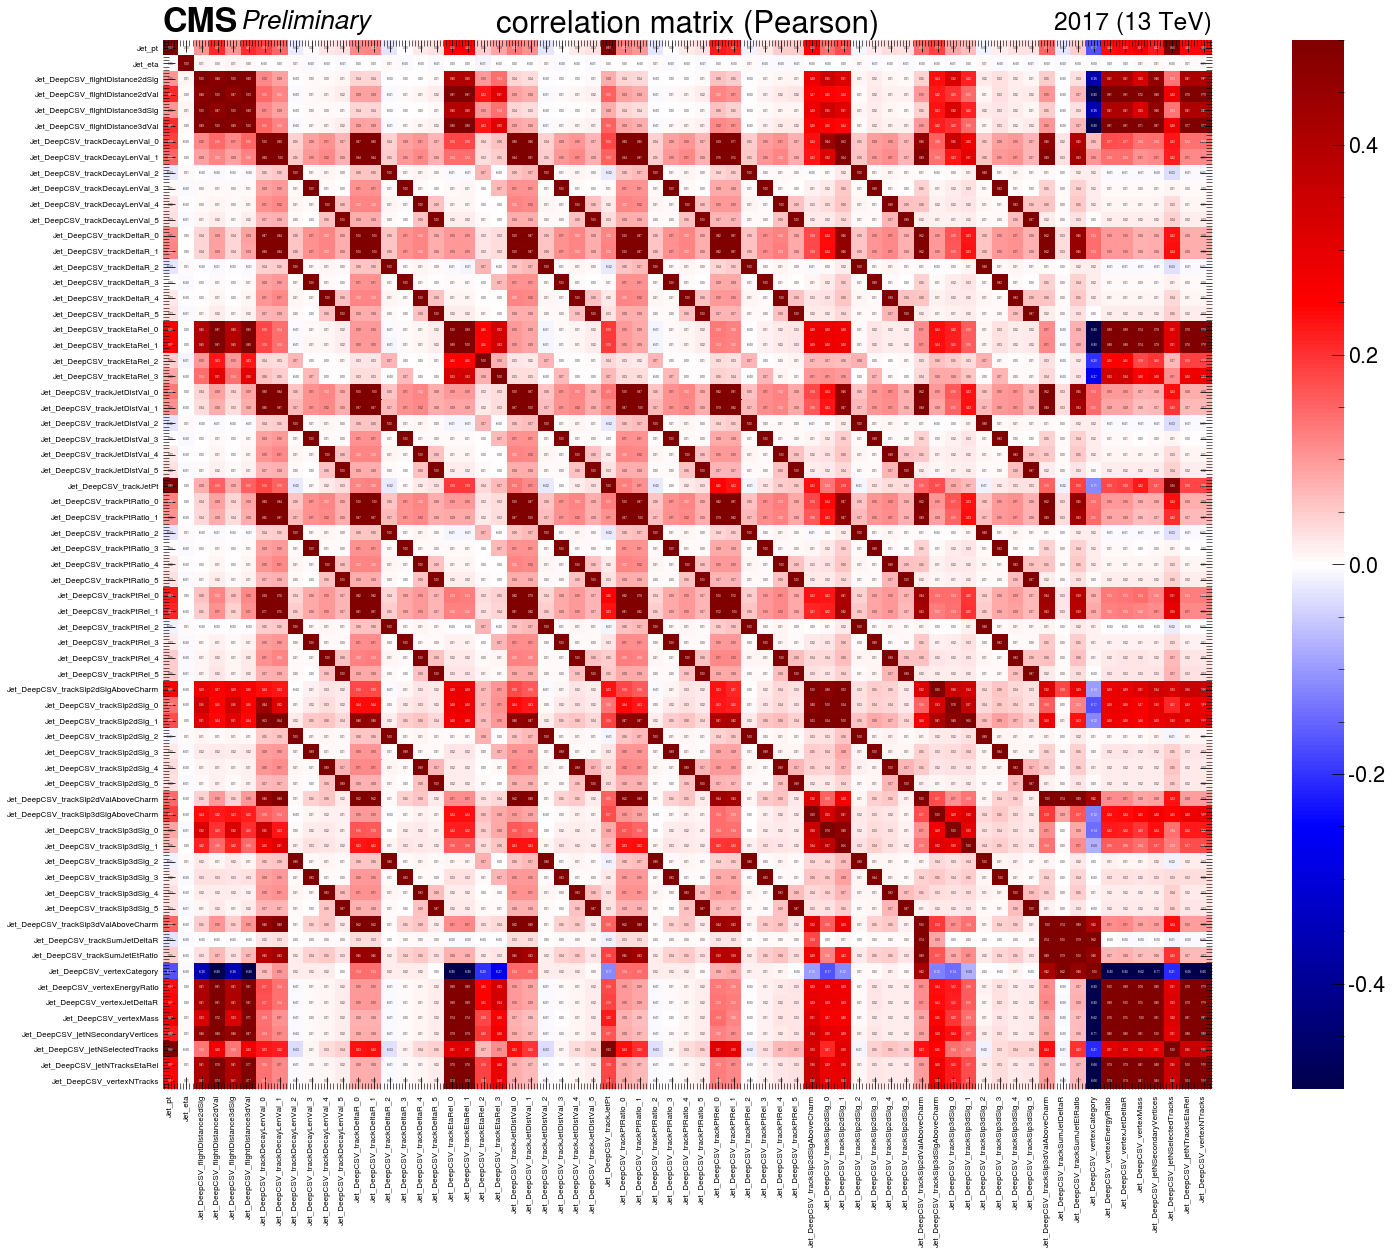

In [78]:
fig, ax = plt.subplots(figsize=(24, 18))
hep.cms.label(loc=0)

hm = sns.heatmap(arr_corr, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.seismic)

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix (Pearson)')
plt.tight_layout()

In [79]:
corr = df[deepCSV_input_branches].corr('kendall')

In [80]:
arr_corr = corr.to_numpy()

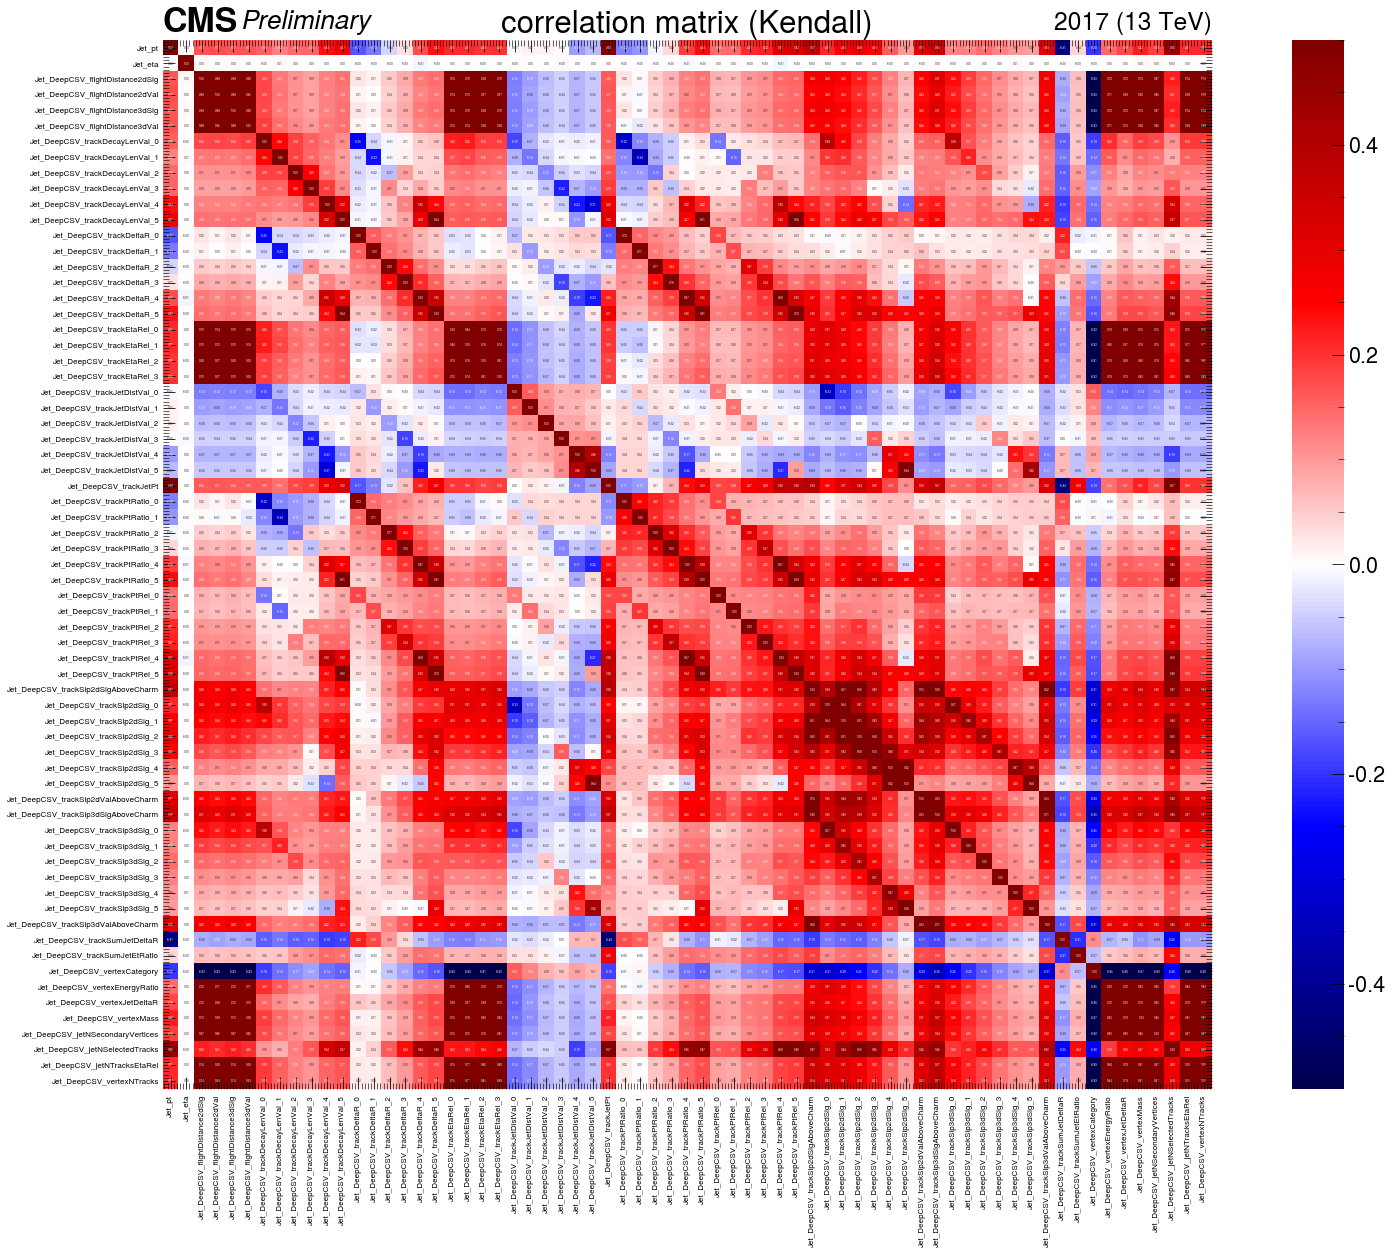

In [81]:
fig, ax = plt.subplots(figsize=(24, 18))
hep.cms.label(loc=0)

hm = sns.heatmap(arr_corr, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.seismic)

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix (Kendall)')
plt.tight_layout()

In [123]:
corr_raw = df[deepCSV_input_branches].corr('spearman')

In [124]:
arr_corr_raw = corr_raw.to_numpy()

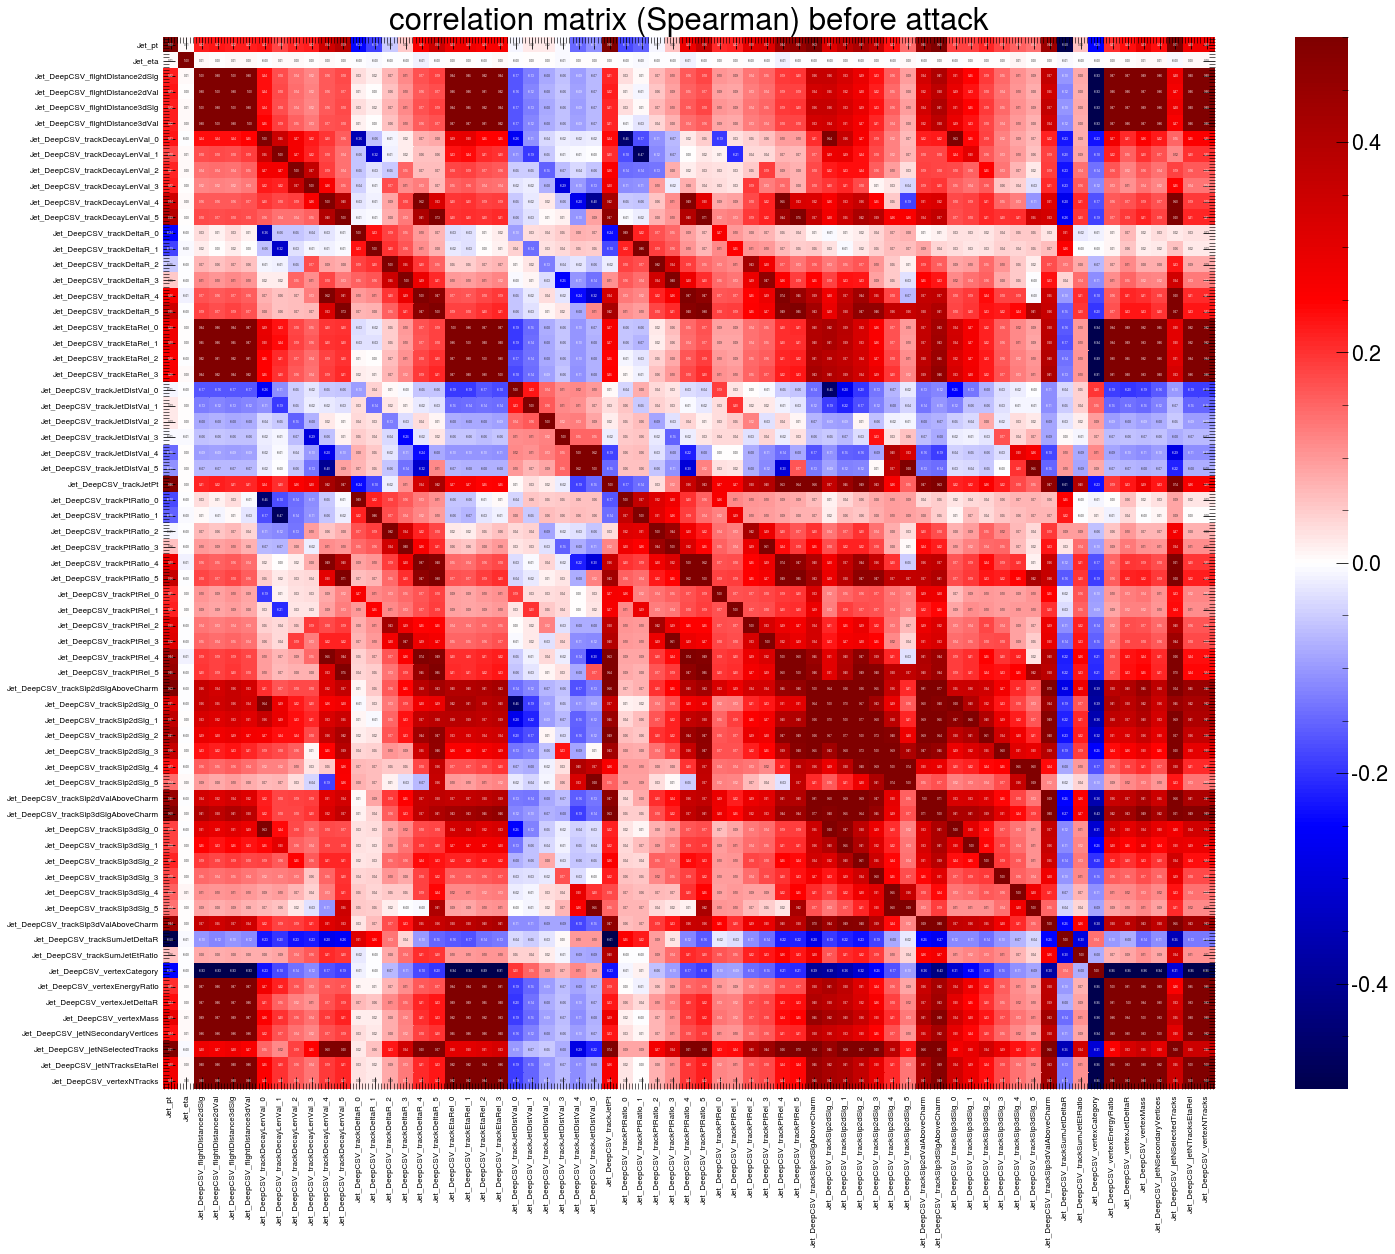

In [125]:
fig, ax = plt.subplots(figsize=(24, 18))
#hep.cms.label(loc=0)

hm = sns.heatmap(arr_corr_raw, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.seismic)

ticks = np.arange(corr_raw.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr_raw.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr_raw.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix (Spearman) before attack')
plt.tight_layout()

## Inputs after applying the attack

So now the inputs have to be prepared in order to use the attack. Cleaning is considered "done", but in order to use the attack, the inputs shall be scaled by (x-mu)/sigma.
Besides that, we need the true target classes as defined in the cleaning & preprocessing steps, otherwise calculations involving the loss function (fgsm) would fail.
And in order to use the correct model, it has be loaded together with the criterion & optimizer.

##### Names to identify the variables, to display them in plots

In [85]:
input_names = ['Jet_eta', 'Jet_pt',
 'Jet_DeepCSV_flightDistance2dSig', 'Jet_DeepCSV_flightDistance2dVal', 'Jet_DeepCSV_flightDistance3dSig', 'Jet_DeepCSV_flightDistance3dVal',
 'Jet_DeepCSV_trackDecayLenVal_0', 'Jet_DeepCSV_trackDecayLenVal_1', 'Jet_DeepCSV_trackDecayLenVal_2', 'Jet_DeepCSV_trackDecayLenVal_3', 'Jet_DeepCSV_trackDecayLenVal_4', 'Jet_DeepCSV_trackDecayLenVal_5',
 'Jet_DeepCSV_trackDeltaR_0', 'Jet_DeepCSV_trackDeltaR_1', 'Jet_DeepCSV_trackDeltaR_2', 'Jet_DeepCSV_trackDeltaR_3', 'Jet_DeepCSV_trackDeltaR_4', 'Jet_DeepCSV_trackDeltaR_5',
 'Jet_DeepCSV_trackEtaRel_0', 'Jet_DeepCSV_trackEtaRel_1', 'Jet_DeepCSV_trackEtaRel_2', 'Jet_DeepCSV_trackEtaRel_3',
 'Jet_DeepCSV_trackJetDistVal_0', 'Jet_DeepCSV_trackJetDistVal_1', 'Jet_DeepCSV_trackJetDistVal_2', 'Jet_DeepCSV_trackJetDistVal_3', 'Jet_DeepCSV_trackJetDistVal_4', 'Jet_DeepCSV_trackJetDistVal_5',
 'Jet_DeepCSV_trackJetPt',
 'Jet_DeepCSV_trackPtRatio_0', 'Jet_DeepCSV_trackPtRatio_1', 'Jet_DeepCSV_trackPtRatio_2', 'Jet_DeepCSV_trackPtRatio_3', 'Jet_DeepCSV_trackPtRatio_4', 'Jet_DeepCSV_trackPtRatio_5',
 'Jet_DeepCSV_trackPtRel_0', 'Jet_DeepCSV_trackPtRel_1', 'Jet_DeepCSV_trackPtRel_2', 'Jet_DeepCSV_trackPtRel_3', 'Jet_DeepCSV_trackPtRel_4', 'Jet_DeepCSV_trackPtRel_5',
 'Jet_DeepCSV_trackSip2dSigAboveCharm',
 'Jet_DeepCSV_trackSip2dSig_0', 'Jet_DeepCSV_trackSip2dSig_1', 'Jet_DeepCSV_trackSip2dSig_2', 'Jet_DeepCSV_trackSip2dSig_3', 'Jet_DeepCSV_trackSip2dSig_4', 'Jet_DeepCSV_trackSip2dSig_5',
 'Jet_DeepCSV_trackSip2dValAboveCharm',
 'Jet_DeepCSV_trackSip3dSigAboveCharm',
 'Jet_DeepCSV_trackSip3dSig_0', 'Jet_DeepCSV_trackSip3dSig_1', 'Jet_DeepCSV_trackSip3dSig_2', 'Jet_DeepCSV_trackSip3dSig_3', 'Jet_DeepCSV_trackSip3dSig_4', 'Jet_DeepCSV_trackSip3dSig_5',
 'Jet_DeepCSV_trackSip3dValAboveCharm',
 'Jet_DeepCSV_trackSumJetDeltaR', 'Jet_DeepCSV_trackSumJetEtRatio',
 'Jet_DeepCSV_vertexCategory', 'Jet_DeepCSV_vertexEnergyRatio', 'Jet_DeepCSV_vertexJetDeltaR', 'Jet_DeepCSV_vertexMass',
 'Jet_DeepCSV_jetNSecondaryVertices', 'Jet_DeepCSV_jetNSelectedTracks', 'Jet_DeepCSV_jetNTracksEtaRel', 'Jet_DeepCSV_vertexNTracks',]

display_names = ['Jet $\eta$',
                'Jet $p_T$',
                'Flight Distance 2D Sig','Flight Distance 2D Val','Flight Distance 3D Sig', 'Flight Distance 3D Val',
                'Track Decay Len Val [0]','Track Decay Len Val [1]','Track Decay Len Val [2]','Track Decay Len Val [3]','Track Decay Len Val [4]','Track Decay Len Val [5]',
                'Track $\Delta R$ [0]','Track $\Delta R$ [1]','Track $\Delta R$ [2]','Track $\Delta R$ [3]','Track $\Delta R$ [4]','Track $\Delta R$ [5]',
                'Track $\eta_{rel}$ [0]','Track $\eta_{rel}$ [1]','Track $\eta_{rel}$ [2]','Track $\eta_{rel}$ [3]',
                'Track Jet Dist Val [0]','Track Jet Dist Val [1]','Track Jet Dist Val [2]','Track Jet Dist Val [3]','Track Jet Dist Val [4]','Track Jet Dist Val [5]',
                'Track Jet $p_T$',
                'Track $p_T$ Ratio [0]','Track $p_T$ Ratio [1]','Track $p_T$ Ratio [2]','Track $p_T$ Ratio [3]','Track $p_T$ Ratio [4]','Track $p_T$ Ratio [5]',
                'Track $p_{T,rel}$ [0]','Track $p_{T,rel}$ [1]','Track $p_{T,rel}$ [2]','Track $p_{T,rel}$ [3]','Track $p_{T,rel}$ [4]','Track $p_{T,rel}$ [5]',
                'Track SIP 2D Sig Above Charm',
                'Track SIP 2D Sig [0]','Track SIP 2D Sig [1]','Track SIP 2D Sig [2]','Track SIP 2D Sig [3]','Track SIP 2D Sig [4]','Track SIP 2D Sig [5]',
                'Track SIP 2D Val Above Charm',
                'Track SIP 3D Sig Above Charm',
                'Track SIP 3D Sig [0]','Track SIP 3D Sig [1]','Track SIP 3D Sig [2]','Track SIP 3D Sig [3]','Track SIP 3D Sig [4]','Track SIP 3D Sig [5]',
                'Track SIP 3D Val Above Charm',
                'Track Sum Jet $\Delta R$','Track Sum Jet $E_T$ Ratio',
                'Vertex Category','Vertex Energy Ratio','Vertex Jet $\Delta R$','Vertex Mass',
                'Jet N Secondary Vertices','Jet N Selected Tracks','Jet N Tracks $\eta_{rel}$','Vertex N Tracks',]

### Loading the model with all its additional properties

In [86]:
criterion = nn.CrossEntropyLoss()

model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

checkpoint = torch.load(f'/home/um106329/aisafety/models/weighted/200_full_files_120_epochs_v13_GPU_weighted_as_is.pt', map_location=torch.device(device))
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

### Creating the true flavour class (target_class) as a new column for the dataframe
Using the definitions from my initial cleandataset function

In [90]:
df["target_class"] = np.full_like(df['Jet_hadronFlavour'], 3)
df["target_class"] = np.where(df['Jet_hadronFlavour'] == 4, 2, df["target_class"])
df["target_class"] = np.where(np.bitwise_and(df['Jet_hadronFlavour'] == 5, df['Jet_nBHadrons'] > 1), 1, df["target_class"])
df["target_class"] = np.where(np.bitwise_and(df['Jet_hadronFlavour'] == 5, df['Jet_nBHadrons'] <= 1), 0, df["target_class"])

And check that the column has been added correctly:

In [91]:
df.head()

,entry,subentry,event,Jet_pt,Jet_eta,Jet_hadronFlavour,Jet_nBHadrons,Jet_btagDeepB,Jet_btagDeepFlavB,Jet_DeepCSV_flightDistance2dSig,...,Jet_DeepCSV_trackSumJetEtRatio,Jet_DeepCSV_vertexCategory,Jet_DeepCSV_vertexEnergyRatio,Jet_DeepCSV_vertexJetDeltaR,Jet_DeepCSV_vertexMass,Jet_DeepCSV_jetNSecondaryVertices,Jet_DeepCSV_jetNSelectedTracks,Jet_DeepCSV_jetNTracksEtaRel,Jet_DeepCSV_vertexNTracks,target_class
0,0,0,-10,671.5000,-0.122818,0,0,0.112854,0.086853,20.640625,...,0.459961,0.0,0.014397,0.187744,0.617188,1,14,2,2,3
1,0,1,-10,448.5000,0.105759,0,0,0.030960,0.021286,-10.000000,...,0.380615,2.0,-10.000000,-10.000000,-10.000000,0,9,0,0,3
2,0,2,-10,270.7500,-0.360352,0,0,0.048584,0.020294,3.375000,...,0.499512,0.0,0.140747,0.066162,1.732422,1,4,4,4,3
3,0,3,-10,41.6875,-0.462341,0,0,0.071228,0.332520,4.468750,...,4.453125,0.0,0.236938,0.072998,5.492188,2,7,4,4,3
4,1,0,-10,400.7500,-0.002752,0,0,0.025467,0.014442,-10.000000,...,0.711426,1.0,0.029877,0.102783,0.333496,0,14,2,2,3


And just some quick checks to find out the unique values of the target_class and Jet N Selected Tracks. It looks like here the cleaning did not erase the 5 tracks bin, although there also happened to be a step where we got rid off all the large values. (Which was found to be the step erasing the 5 tracks bin from my older datasets).

In [92]:
df.target_class.unique()

array([3, 2, 0, 1])

In [93]:
df.Jet_DeepCSV_jetNSelectedTracks.unique()

array([14,  9,  4,  7, 10,  5,  6,  2, 12,  3,  1, 15,  8, 11, 13,  0, 17,
       16, 20, 19, 22, 18, 21, 24, 26, 23, 25])

In [97]:
targets = torch.Tensor(df["target_class"].to_numpy()).long()

In [98]:
targets

tensor([3, 3, 3,  ..., 3, 3, 3])

### Scaling the cleaned inputs (this method will not be used)

In [87]:
# scales the dataframe, result has lost the indices and names (is basically usable just like a numpy array)
#scaled_features = StandardScaler().fit_transform(df[deepCSV_input_branches].values)

In [88]:
# reassign indices / column names
#scaled_features_df = pd.DataFrame(scaled_features, index=df[deepCSV_input_branches].index, columns=df[deepCSV_input_branches].columns)

In [89]:
#scaled_features

array([[ 2.05351352, -0.10730655,  1.01863401, ...,  1.93711069,
         0.19603161,  0.19603161],
       [ 0.96001248,  0.0906588 , -0.3251782 , ...,  0.61066668,
        -0.62502937, -0.62502937],
       [ 0.08839898, -0.31302928,  0.26141193, ..., -0.71577733,
         1.01709259,  1.01709259],
       ...,
       [ 1.47979324,  0.87867451, -0.3251782 , ..., -1.24635494,
        -0.62502937, -0.62502937],
       [ 0.76877239, -0.49476622,  0.23203103, ...,  0.61066668,
         2.24868406,  2.24868406],
       [-0.95959059, -0.61899013, -0.3251782 , ..., -0.18519973,
        -0.62502937, -0.62502937]])

### Scaling the cleaned inputs

In [99]:
all_inputs = torch.Tensor(df[deepCSV_input_branches].values[:,0:67])
norm_inputs = all_inputs.clone().detach()

scalers = []
    
for i in range(0,67):
    scaler = StandardScaler().fit(all_inputs[:,i].reshape(-1,1))
    norm_inputs[:,i] = torch.Tensor(scaler.transform(all_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    scalers.append(scaler)


Should now have: scaled inputs (norm_inputs), scalers ready to be used with pytorch

In [104]:
method = 0

In [133]:
n_jets = len(norm_inputs)
n_jets

34479

In [105]:
def fgsm_attack(epsilon=1e-1,sample=None,targets=None,reduced=True, scalers=None,method=None):
    xadv = sample.clone().detach()
    
    # calculate the gradient of the model w.r.t. the *input* tensor:
    # first we tell torch that x should be included in grad computations
    xadv.requires_grad = True
    
    # then we just do the forward and backwards pass as usual:
    preds = model(xadv)
    loss = criterion(preds, targets.long()).mean()
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        #now we obtain the gradient of the input. It has the same dimensions as the tensor xadv, and it "points" in the direction of increasing loss values.
        dx = torch.sign(xadv.grad.detach())
        
        #so, we take a step in that direction!
        xadv += epsilon*torch.sign(dx)
        
        #remove the impact on selected variables. This is nessecary to avoid problems that occur otherwise in the input shapes.
        if reduced:
            #xadv[:,2] = sample[:,2]     # TagVarCSV_jetNSecondaryVertices
            xadv[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')] = sample[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')]
            #xadv[:,5] = sample[:,5]     # TagVarCSV_vertexCategory
            xadv[:,input_names.index('Jet_DeepCSV_vertexCategory')] = sample[:,input_names.index('Jet_DeepCSV_vertexCategory')]
            #xadv[:,10] = sample[:,10]   # TagVarCSV_jetNSelectedTracks
            xadv[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')] = sample[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')]
            #xadv[:,11] = sample[:,11]   # TagVarCSV_jetNTracksEtaRel
            xadv[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')] = sample[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')]
            #xadv[:,59] = sample[:,59]   # TagVarCSV_vertexNTracks
            xadv[:,input_names.index('Jet_DeepCSV_vertexNTracks')] = sample[:,input_names.index('Jet_DeepCSV_vertexNTracks')]
            #xadv[:,12:][sample[:,12:]==0] = 0   # TagVarCSVTrk_trackJetDistVal and so forth, but I have not set any variable to 0 manually during cleaning
            #xadv[:,input_names.index('Jet_DeepCSV_trackJetDistVal_0'):][sample[:,input_names.index('Jet_DeepCSV_trackJetDistVal_0'):] == 0] = 0
            for i in [41, 48, 49, 56]:
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu()) + 1.0) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in [41, 48, 49, 56]:
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
            vars_with_0_defaults = [6, 7, 8, 9, 10, 11]                 # trackDecayLenVal_0 to _5
            vars_with_0_defaults.extend([12, 13, 14, 15, 16, 17])       # trackDeltaR_0 to _5
            vars_with_0_defaults.extend([18, 19, 20, 21])               # trackEtaRel_0 to _3
            vars_with_0_defaults.extend([22, 23, 24, 25, 26, 27])       # trackJetDistVal_0 to _5
            vars_with_0_defaults.extend([29, 30, 31, 32, 33, 34])       # trackPtRatio_0 to _5
            vars_with_0_defaults.extend([35, 36, 37, 38, 39, 40])       # trackPtRel_0 to _5
            for i in vars_with_0_defaults:
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu())) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in vars_with_0_defaults:
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
        return xadv.detach()
  

In [117]:
epsilon = 0.005

In [106]:
xadv = fgsm_attack(epsilon,all_inputs,targets,reduced=True,scalers=scalers,method=method)

In [112]:
xadv_scaled_back = np.zeros([n_jets,67])
for prop in range(67):
    xadv_scaled_back[:,prop] = scalers[prop].inverse_transform(xadv[:,prop])

In [113]:
xadv_scaled_back

array([[ 1.37193141e+05, -1.40727967e-01,  4.68046967e+02, ...,
         5.94707794e+01,  6.39423704e+00,  6.39423704e+00],
       [ 9.17162812e+04,  1.23193428e-01, -2.30598221e+02, ...,
         4.06233978e+01,  1.52249193e+00,  1.52249193e+00],
       [ 5.54673477e+04, -4.14991289e-01,  7.43687592e+01, ...,
         2.17760143e+01,  1.12659826e+01,  1.12659826e+01],
       ...,
       [ 1.13333086e+05,  1.17375207e+00, -2.30598221e+02, ...,
         1.42370596e+01,  1.52249193e+00,  1.52249193e+00],
       [ 8.37629297e+04, -6.57277465e-01,  5.90936928e+01, ...,
         4.06233978e+01,  1.85736008e+01,  1.85736008e+01],
       [ 1.18832275e+04, -8.22889030e-01, -2.30598221e+02, ...,
         2.93149681e+01,  1.52249193e+00,  1.52249193e+00]])

In [126]:
xadv_df = pd.DataFrame(xadv_scaled_back, index=df[deepCSV_input_branches].index, columns=df[deepCSV_input_branches].columns)

In [127]:
corr_xadv = xadv_df[deepCSV_input_branches].corr('spearman')

In [128]:
arr_corr_xadv = corr_xadv.to_numpy()

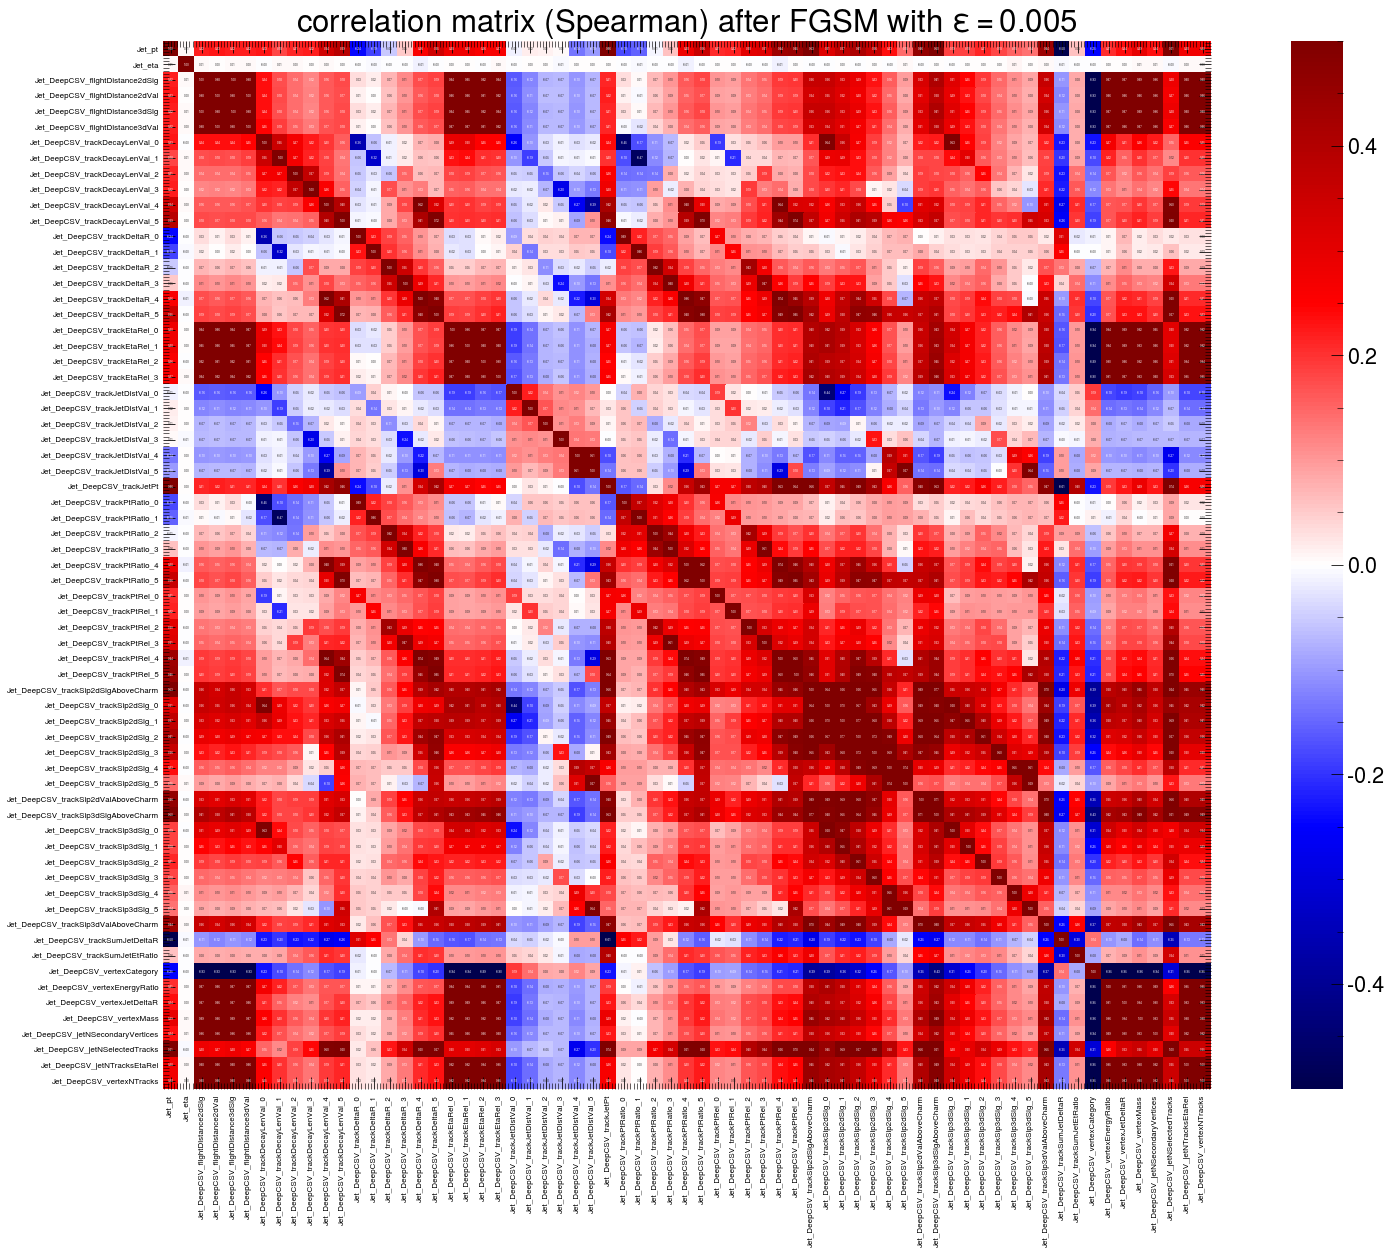

In [129]:
fig, ax = plt.subplots(figsize=(24, 18))
#hep.cms.label(loc=0)

hm = sns.heatmap(arr_corr_xadv, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.seismic)

ticks = np.arange(corr_xadv.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr_xadv.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr_xadv.index, rotation=360, fontsize=8)

ax.set_title(f'correlation matrix (Spearman) after FGSM with $\epsilon={epsilon}$')
plt.tight_layout()

Now it would be interesting to look at the difference between before and after attack. Idea: just subtract the correlation matrices, and create a heatmap from this difference (before - after), just like before.

In [130]:
difference = arr_corr_raw - arr_corr_xadv
# wouldn't have thought that one can subtract this type of multidimensional stuff in one line, but ok :)

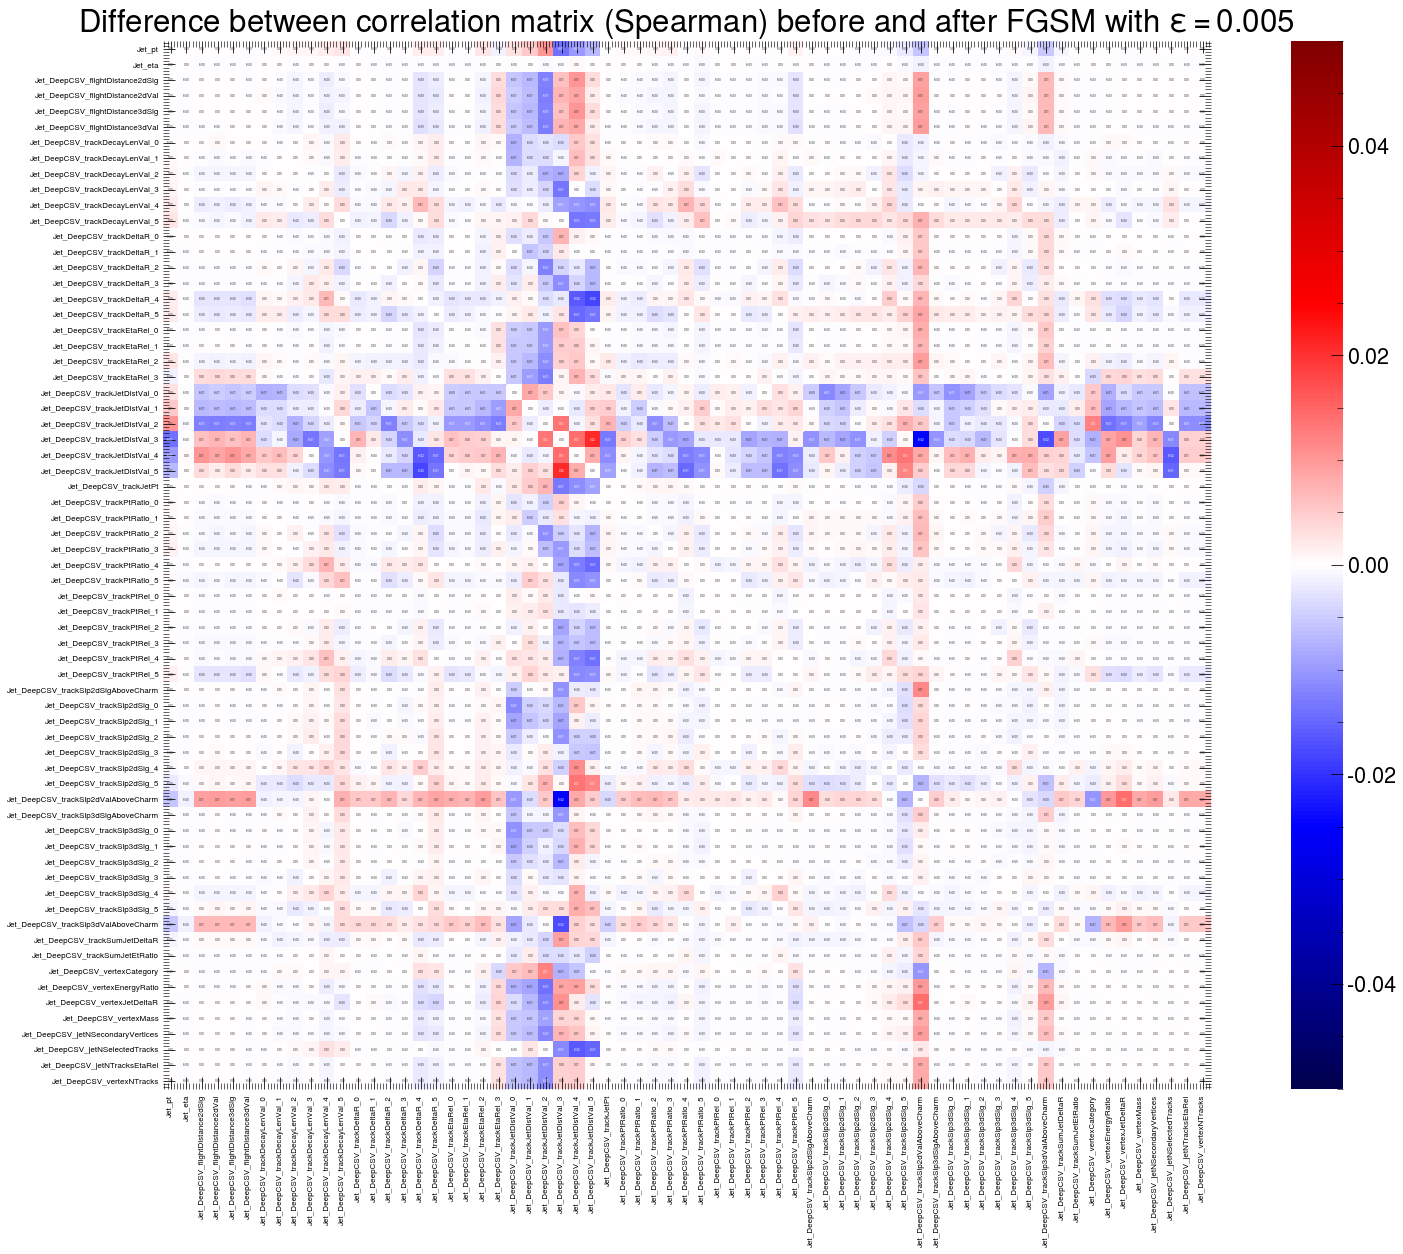

In [132]:
fig, ax = plt.subplots(figsize=(24, 18))
#hep.cms.label(loc=0)

hm = sns.heatmap(difference, cbar=True, vmin=-0.05, vmax=0.05,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.seismic)

ticks = np.arange(corr_xadv.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr_xadv.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr_xadv.index, rotation=360, fontsize=8)

ax.set_title(f'Difference between correlation matrix (Spearman) before and after FGSM with $\epsilon={epsilon}$')
plt.tight_layout()